In [30]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM, z_at_value

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv', usecols=['Use', 'zpk', 'LIR', 'F24'])
CDFS = pd.DataFrame(data)
CDFS['source'] = 'CDFS'

data = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN.csv', usecols=['Use', 'zpk', 'LIR', 'F24'])
COSMOS = pd.DataFrame(data)
COSMOS['source'] = 'COSMOS'

data = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN.csv', usecols=['Use', 'zpk', 'LIR', 'F24'])
UDS = pd.DataFrame(data)
UDS['source'] = 'UDS'

df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True)
df = df[df['LIR'] > 0]
df = df[df['Use'] == 1]

z_bins = [(0, 0.3), (0.3, 0.45), (0.45, 0.6), (0.6, 0.8), 
          (0.8, 1.0), (1.0, 1.2), (1.2, 1.7), (1.7, 2.0),
          (2.0, 2.5), (2.5, 3.0), (3.0, 4.2), (4.2, 6.0)] # redshift bins

all_percentiles = [25, 25, 25, 20,
               20, 20, 25, 20,
               20, 25, 50, 35] # percentiles for each redshift bin all ZFOURGE

names = ['CDFS', 'COSMOS', 'UDS']
shapes = ['o', 's', '^']
colours = ['C0', 'C1', 'C2']

# Bolometric luminosity
lum = df['LIR'].copy().values # solar luminosity
lum_watts = lum*3.828*10**26 # solar luminosity -> watts
lum_watts = np.array(lum_watts.tolist())
z = df['zpk'].values # redshift

# Luminosity distance
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to(u.m).value # m

# Flux limit
Flim = 0.003 # mJy
mask_f = df['F24'] > Flim

# Percentile cut
F_bol = lum_watts / (4 * np.pi * d_L ** 2) # W/m^2
all_F_lims = []
for (z_start, z_end), per in zip(z_bins, all_percentiles):
    mask_z = (z >= z_start) & (z < z_end)
    p = np.percentile(F_bol[mask_z], per) # 80% of the data is above this value
    all_F_lims.append(p)
    
reg = np.load('fits/log_good_lf.npz', allow_pickle=True)

C:\Users\danie\AppData\Local\Temp\ipykernel_3864\2877775630.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


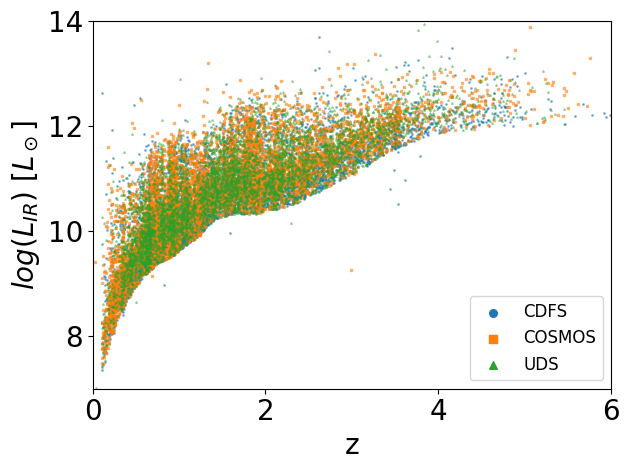

In [31]:
mask_f = df['F24'] > Flim
for name, shape in zip(names, shapes):
    mask_n = df['source'] == name
    plt.scatter(z[mask_n & mask_f], np.log10(lum[mask_n & mask_f]), s=1, alpha=0.5, label=name, marker=shape)
    
plt.xlabel('z', fontsize=20)
plt.ylabel('$log(L_{IR})$ [$L_\odot$]', fontsize=20)
plt.xlim(0, 6)
plt.ylim(7, 14)
plt.xticks([0,2,4,6], fontsize=20)
plt.yticks([8,10,12,14], fontsize=20)
legend = plt.legend(fontsize=12)
for handle in legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1)
plt.tight_layout()
plt.show()

In [ ]:
n = len(all_F_lims)
cm = plt.get_cmap('gist_rainbow')
fig, ax = plt.subplots()
ax.set_prop_cycle(color=[cm(1.*i/n) for i in range(n)])

for name, shape, c in zip(names, shapes, colours):
    mask_n = df['source'] == name
    plt.scatter(z[mask_n & mask_f], np.log10(lum[mask_n & mask_f]), s=1, alpha=0.2, marker=shape, color=c)

for (z_start, z_end), F_lim in zip(z_bins, all_F_lims):
    mask_z = (z >= z_start) & (z < z_end)
    mask_flux = F_bol > F_lim
    
    dmaxs = np.sqrt(lum_watts[mask_z & mask_flux] / (4 * np.pi * F_lim)) # sqrt(W / W/m^2) = sqrt(m^2) = m
    dmaxs *= 3.241 * 10 **-23 # m -> Mpc
    
    rb_max = cosmo.luminosity_distance(z_end).value
    mask_d = dmaxs <= rb_max
    
    z_lim = z_at_value(cosmo.luminosity_distance, dmaxs[mask_d] * u.Mpc)
    plt.scatter(z_lim, np.log10(lum[mask_z & mask_flux][mask_d]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    
plt.xlabel('z', fontsize=20)
plt.ylabel('$log(L_{IR})$ [$L_\odot$]', fontsize=20)
plt.xticks([0,2,4,6], fontsize=20)
plt.yticks([8,10,12,14], fontsize=20)
plt.xlim(0, 6)
plt.ylim(7, 14)
legend = plt.legend(ncols=2)
for handle in legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1)
plt.tight_layout()
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_3864\3301576274.py:80: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


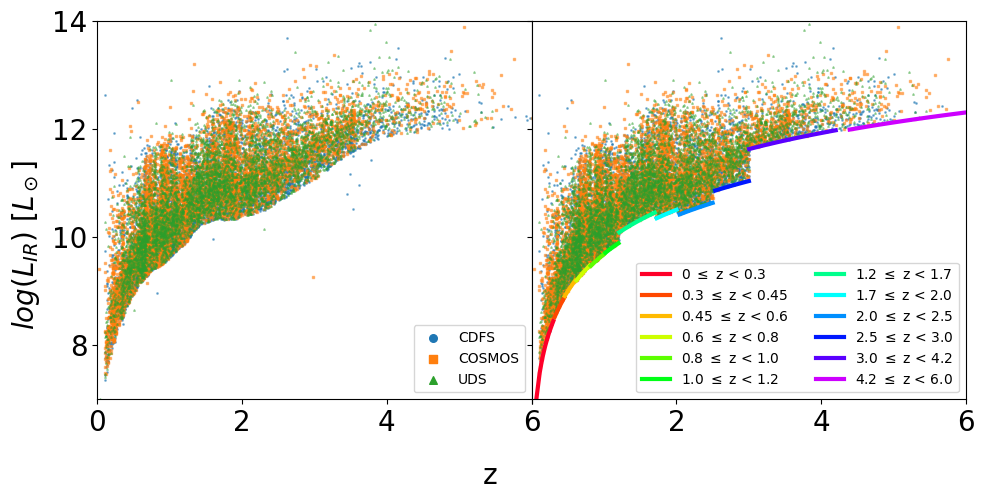

In [34]:
n = len(all_F_lims)
cm = plt.get_cmap('gist_rainbow')
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[1].set_prop_cycle(color=[cm(1.*i/n) for i in range(n)])
axes = ax.flatten()

axes[0].set_xticks([0,2,4,6])
axes[0].set_yticks([8,10,12,14])
axes[0].set_xlim(0, 6)
axes[0].set_ylim(7, 14)
ax[0].set_yticks([8,10,12,14])
ax[0].tick_params(axis='both', labelsize=20)
ax[1].tick_params(axis='both', labelsize=20)

# Luminsity distance of galaxies
new_luminosity = df['LIR'].copy().values # solar luminosity
new_luminosity *= 3.828 * 10 ** 26 # Solar luminosity -> Watts
z = df['zpk'].copy().values # redshift

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to('m').value # m

F_bol = new_luminosity / (4 * np.pi * d_L ** 2) # W/m^2

F_lims = []
for (z_start, z_end), perc in zip(z_bins, all_percentiles):
    mask_z = (z >= z_start) & (z < z_end)
    p = np.percentile(F_bol[mask_z], perc) # % of the data above perc
    F_lims.append(p)
    mask_f = F_bol <= p
    new_luminosity[mask_f & mask_z] = 0 # remove galaxies with flux below p

mask_f = df['F24'] > Flim
colours = ['C0', 'C1', 'C2']
for name, shape, c in zip(names, shapes, colours):
    mask_n = df['source'] == name
    axes[0].scatter(z[mask_n & mask_f], np.log10(lum[mask_n & mask_f]), s=1, marker=shape, alpha=0.5, color=c, label=name)
    
# Remove galaxies with no new_luminosity
mask_l = new_luminosity > 0
new_luminosity = new_luminosity[mask_l]
z = z[mask_l]
d_L = d_L[mask_l]
new_df = df[mask_l].copy()
F_bol = F_bol[mask_l]
lum_w = lum[mask_l].copy()

# Maximum distance of galaxies (eq 2)
dmaxs = np.zeros(len(new_luminosity))
for (z_start, z_end), F_lim in zip(z_bins, F_lims):
    mask_z = (z >= z_start) & (z < z_end)
    dmaxs[mask_z] = np.sqrt(new_luminosity[mask_z] / (4 * np.pi * F_lim))

colours = ['C0', 'C1', 'C2']
for name, shape, c in zip(names, shapes, colours):
    mask_n = new_df['source'] == name
    axes[1].scatter(z[mask_n], np.log10(new_luminosity[mask_n]*2.612*10**-27), s=1, marker=shape, alpha=0.5, color=c)

for (z_start, z_end), F_lim in zip(z_bins, all_F_lims):
    mask_z = (z >= z_start) & (z < z_end)
    mask_flux = F_bol > F_lim
    
    dmaxs = np.sqrt(new_luminosity[mask_z & mask_flux] / (4 * np.pi * F_lim)) # sqrt(W / W/m^2) = sqrt(m^2) = m
    dmaxs *= 3.241 * 10 **-23 # m -> Mpc
    
    rb_max = cosmo.luminosity_distance(z_end).value
    mask_d = dmaxs <= rb_max
    
    z_lim = z_at_value(cosmo.luminosity_distance, dmaxs[mask_d] * u.Mpc)
    
    # order x increasing
    idx = np.argsort(z_lim)
    
    axes[1].plot(z_lim[idx], np.log10(lum_w[mask_z & mask_flux][mask_d][idx]), label=f'{z_start} $\leq$ z < {z_end}', linewidth=3)
    
fig.supxlabel('z', fontsize=20)
fig.supylabel('$log(L_{IR})$ [$L_\odot$]', fontsize=20)

legend = axes[0].legend()
for handle in legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1)

axes[1].legend(ncols=2)

xticks = axes[1].xaxis.get_major_ticks()
xticks[0].label1.set_visible(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('lir_vs_z_cutoffx2.png')
plt.show()

In [ ]:
# Luminsity distance of galaxies
lum = df['LIR'].copy().values # solar luminosity
lum *= 3.828 * 10 ** 26 # Solar luminosity -> Watts
z = df['zpk'].copy().values # redshift

d_L = cosmo.luminosity_distance(z).to('m').value # m

F_lim = 0.003 # mJy
mask_f_min = df['F24'] >= F_lim
mask_f_max = df['F24'] <= F_lim+0.001

d_L *= 3.241*10**-23 # m -> Mpc

plt.scatter(d_L[mask_f_min], np.log10(lum[mask_f_min]), s=1)
plt.scatter(d_L[mask_f_min & mask_f_max], np.log10(lum[mask_f_min & mask_f_max]), s=1)
plt.xlim(0, 80000)
plt.show()